<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/BERT_FIQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset FiQA
> [Link do dataset](https://sites.google.com/view/fiqa/home?authuser=0)

Inspirado no github:
> [Yuanbit](https://github.com/yuanbit/FinBERT-QA/)

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 890kB 5.4MB/s 
     |████████████████████████████████| 3.0MB 17.4MB/s 
     |████████████████████████████████| 890kB 60.9MB/s 
     |████████████████████████████████| 1.1MB 50.8MB/s 


In [ ]:
# basic
import os
import math 
import pickle
import random
import logging
import numpy as np
import pandas as pd
from statistics import mean
from itertools import combinations

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# torch
import torch
from torch.utils.data import random_split, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.nn.functional import softmax

# transformers
from transformers import (BertTokenizer, BertForSequenceClassification, 
                          AdamW, get_linear_schedule_with_warmup, BertConfig)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
manual_seed = 2357

def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Experimento deterministico, seed: {manual_seed} -- ', end = '')
        print(f'Existe {torch.cuda.device_count()} GPU {torch.cuda.get_device_name(0)} disponível.')
    else:
        print('Experimento randomico')

deterministic()

Experimento deterministico, seed: 2357 -- Existe 1 GPU Tesla T4 disponível.


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_dataset = '/content/drive/My Drive/Colab Notebooks/Colab Notebooks/BERT/FinBERT/data/raw/'

df_questions = pd.read_csv(path_dataset+'FiQA_train_question_final.tsv', sep='\t', index_col=0)
df_docs = pd.read_csv(path_dataset+'FiQA_train_doc_final.tsv', sep='\t', index_col=0)
df_labels = pd.read_csv(path_dataset+'FiQA_train_question_doc_final.tsv', sep='\t', index_col=0)

print(f'Shape do dataset das questions: {df_questions.shape:}')
print(f'Shape do dataset dos docs:      {df_docs.shape}')
print(f'Shape do dataset das labels:    {df_labels.shape}')

Shape do dataset das questions: (6648, 3)
Shape do dataset dos docs:      (57638, 3)
Shape do dataset das labels:    (17110, 2)


In [ ]:
df_questions.head(3)

,qid,question,timestamp
0,0,What is considered a business expense on a bus...,Nov 8 '11 at 15:14
1,1,Claiming business expenses for a business with...,May 13 '14 at 13:17
2,2,Transferring money from One business checking ...,Jan 20 '16 at 20:31


In [ ]:
df_docs.head(3)

,docid,doc,timestamp
0,3,I'm not saying I don't like the idea of on-the...,Oct 03 '12 at 14:56
1,31,So nothing preventing false ratings besides ad...,Sep 01 '17 at 13:36
2,56,You can never use a health FSA for individual ...,Jun 9 '14 at 17:37


In [ ]:
df_labels.head(3)

,qid,docid
0,0,18850
1,1,14255
2,2,308938


# Subamostragem
> um pedaço do dataset, motivo: conseguir treinar mais rápido.

### Subsamostragem das labels

In [ ]:
df_labels_sub = df_labels[:300] 

questions_sub = list(set(df_labels_sub.qid.to_list()))
docs_rel = list(set(df_labels_sub.docid.to_list()))
print(f'Qtde de questions subsampling: {len(questions_sub)}')
print(f'Qtde de docs rel. subsampling: {len(docs_rel)}')

print(f'df_labels_sub shape: {df_labels_sub.shape}\n')
df_labels_sub.head(3)

Qtde de questions subsampling: 160
Qtde de docs rel. subsampling: 300
df_labels_sub shape: (300, 2)



,qid,docid
0,0,18850
1,1,14255
2,2,308938


### Subsamostragem dos documentos/respostas

In [ ]:
# docs irrelevantes (não é reposta de nenhum qid)
noise_docs = df_docs[~df_docs.docid.isin(docs_rel)][:2000]

# docs relevantes é reposta de alguma qid
docs_with_answer = df_docs[df_docs.docid.isin(docs_rel)]

# subsampling docs: (docs rel. + docs irrel.)
df_docs_sub = pd.concat((docs_with_answer, noise_docs), axis=0)

# dict com codid -> doc
docid_to_text = {k:v for k,v in zip(df_docs.docid.to_list(), df_docs.doc.to_list())}
print(f'df_docs_sub shape: {df_docs_sub.shape}')
df_docs_sub.head(3)

df_docs_sub shape: (2300, 3)


,docid,doc,timestamp
1230,13013,There are a number of mutual funds which claim...,Aug 25 '15 at 20:04
1338,14255,Yes you can claim your business deductions if ...,May 14 '14 at 8:07
1795,18792,You are confining the way you and the other co...,Feb 20 at 22:47


### Subsamostragem das questões

In [ ]:
df_questions_sub = df_questions[df_questions.qid.isin(questions_sub)]

# dict com qid -> question
qid_to_text = {k:v for k,v in zip(df_questions.qid.to_list(), df_questions.question.to_list())}
print(f'df_questions_sub shape: {df_questions_sub.shape}')
df_questions_sub.head(3)

df_questions_sub shape: (160, 3)


,qid,question,timestamp
0,0,What is considered a business expense on a bus...,Nov 8 '11 at 15:14
1,1,Claiming business expenses for a business with...,May 13 '14 at 13:17
2,2,Transferring money from One business checking ...,Jan 20 '16 at 20:31


# Prep data

## Agrupando os labels por qid

In [ ]:
df_labels_sub = df_labels_sub.assign(qid = df_labels_sub.qid.apply(lambda x: int(x)))
df_labels_sub = df_labels_sub.assign(docid = df_labels_sub.docid.apply(lambda x: int(x)))

labels_group = df_labels_sub.groupby(['qid']).agg(lambda x: tuple(x)).applymap(list).reset_index()

TRAIN_SIZE = 130 # simples slit do dataset

train_data = labels_group[:TRAIN_SIZE]
labels_train = {k:v for k,v in zip(train_data.qid.to_list(), train_data.docid.to_list())}

valid_data = labels_group[TRAIN_SIZE:] 
labels_valid = {k:v for k,v in zip(valid_data.qid.to_list(), valid_data.docid.to_list())}

train_data

,qid,docid
0,0,[18850]
1,1,[14255]
2,2,[308938]
3,3,"[296717, 100764, 314352, 146317]"
4,4,[196463]
...,...,...
125,468,"[498927, 536760]"
126,469,"[250939, 549432]"
127,470,[45078]
128,471,"[158122, 494625]"


#### Se o docid para uma query possui mais de um elemento na lista, vamos sortear as respostas candidadas com relação ao tamanho da lista

In [ ]:
def make_dataset(df, number_of_cands=30):
    # num. de candidatos por amostra
    K = number_of_cands

    # dataset 
    df_ = df.copy() # cols: df[['qid'], ['docid']]

    # lista que armazenará o shape final do dataset
    data = []

    # candidatos a resposta
    cands_dataset = []

    # para cada linha do df...
    for i, row_data in enumerate(df_.iterrows()):

        cands_dataset = []
        
        # sorteia cands aleatórias  
        docs_choice = list(np.random.choice(df_docs.docid, 2 * K, replace=False))
        
        # adiciona as cands na lista 
        cands_dataset.extend(docs_choice)
        
        # anexa os labels na lista faz o set, emaralha e trunca em K
        set_list_cands = list(set(row_data[1].docid + cands_dataset))
        
        cands = random.sample(set_list_cands, len(set_list_cands))[:K]

        # descarta as amostras que não possuem o número de cands = K  
        if len(cands) == K:    
            data.append([row_data[1].qid, row_data[1].docid, cands])

    return data # list [[qid], [labels], [cands]]    

#---------------------------------------------
data_train = make_dataset(train_data, 40)
data_valid = make_dataset(valid_data, 40)
data_train.pop(116)
print(f'Amostras de treino: {len(data_train)} -- Amostras de valid: {len(data_valid)}')        

Amostras de treino: 129 -- Amostras de valid: 30


# Estudo do tam. das amostras do dataset

In [ ]:
def get_input_tokenized_lenghts(dataset):

    # remove o warning do log
    logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

    lengths = []

    for i, seq in enumerate(dataset):
        qid, ans_labels, cands = seq[0], seq[1], seq[2]

        # Mapeia o id da pergunta para o texto
        q_text = qid_to_text[qid]

        # Para cada id de resposta em respostas candidatas
        for docid in cands:
            # Mapeia o docid para o texto
            ans_text = docid_to_text[docid]
            input_ids = tokenizer.encode(
                q_text, 
                ans_text,
                add_special_tokens = True)

            lengths.append(len(input_ids))
    return lengths

#-----------------------------------------------------
lengths = get_input_tokenized_lenghts(data_train)

print(f' comp. Min: {min(lengths):>8} tokens')
print(f' comp. Max: {max(lengths):>8} tokens')
print(f' comp. Mediano: {np.median(lengths):,} tokens')

   comp. Min:     18 tokens
   comp. Max:    2675 tokens
   comp. Mediano: 132.0 tokens


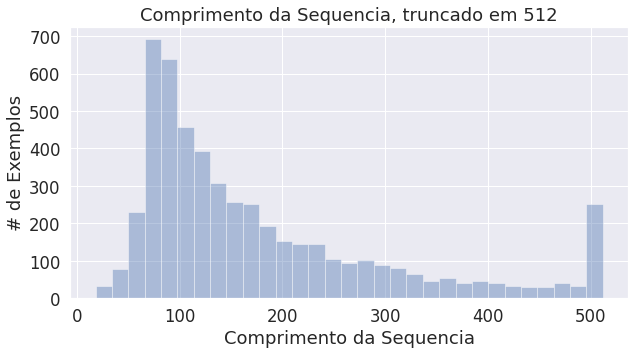

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

trunc_lengths = [min(l, 512) for l in lengths]

sns.distplot(trunc_lengths, kde=False, rug=False)

plt.title('Comprimento da Sequencia, truncado em 512')
plt.xlabel('Comprimento da Sequencia')
plt.ylabel('# de Exemplos')
plt.show()

In [ ]:
lengths = np.asarray(lengths)

num_comments = len(lengths)
max_lens = [128, 256, 300, 384, 512]

print('Quantas entradas serão truncadas?\n')

for max_len in max_lens:
    num_over = np.sum(lengths > max_len)
    prcnt_over = float(num_over) / float(num_comments)
    print(f'max_len = {max_len:} --> {num_over:>5,} de ' \
    f'{num_comments:>5,}  ({prcnt_over:>5.1%}) serão truncadas')

Quantas entradas serão truncadas?

max_len = 128 --> 2,661 de 5,160  (51.6%) serão truncadas
max_len = 256 --> 1,086 de 5,160  (21.0%) serão truncadas
max_len = 300 -->   809 de 5,160  (15.7%) serão truncadas
max_len = 384 -->   510 de 5,160  ( 9.9%) serão truncadas
max_len = 512 -->   227 de 5,160  ( 4.4%) serão truncadas


In [ ]:
def get_input_data(dataset, max_seq_len=384):
    all_input_ids, attention_masks, segment_ids, labels = [], [], [], []
    
    # remove o warning do log
    logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

    for i, seq in enumerate(dataset):

        qid, ans_labels, cands = seq[0], seq[1], seq[2]

        # Mapeia a questão para o texto
        q_text = qid_to_text[qid]

        # Para cada resposta naas candidatas...
        for docid in cands:
            # Mapeia o docid para o texto
            ans_text = docid_to_text[docid]
            
            # Codifica a sequencia usanso o tokenizador
            encoded_seq = tokenizer.encode_plus(
                q_text, 
                ans_text,
                max_length=max_seq_len,
                pad_to_max_length=True,
                return_token_type_ids=True,
                return_attention_mask=True,
                return_tensors = 'pt'
                )

            # Se uma resposta na lista é relevante é um label positivo
            if docid in ans_labels:
                label = 1
            # caso contrário é um label negativo
            else:
                label = 0
            
                
            # Verifica se os tamanhos estão corretos
            assert encoded_seq['input_ids'].shape[1] == max_seq_len, "dim. do Input esta errada!"
            assert encoded_seq['token_type_ids'].shape[1] == max_seq_len, "dim. do token_type_id esta errada!"
            assert encoded_seq['attention_mask'].shape[1] == max_seq_len, "dim. da attention_mask esta errada!"

            all_input_ids.append(encoded_seq['input_ids'])
            segment_ids.append(encoded_seq['token_type_ids'])
            attention_masks.append(encoded_seq['attention_mask'])
            labels.append(label)

    all_input_ids = torch.cat(all_input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    segment_ids = torch.cat(segment_ids, dim=0)
    
    return all_input_ids, attention_masks, segment_ids, labels

# teste de sanidade
all_input_ids, attention_masks, segment_ids, labels = get_input_data(data_valid, 384)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
MAX_LEN = 384
BATCH_SZ = 16

#-----------------------------------__DATASETS__-----------------------------------
# cria o dataset de treino
all_input_ids_T, attention_masks_T, segment_ids_T, labels_T = get_input_data(
    data_train, 
    MAX_LEN
    )

ds_train = TensorDataset(
    all_input_ids_T, 
    attention_masks_T, 
    segment_ids_T, 
    torch.tensor(labels_T)
    )

# cria o dataset de validação
all_input_ids_V, attention_masks_V, segment_ids_V, labels_V = get_input_data(
    data_valid, 
    MAX_LEN
    )
ds_val = TensorDataset(
    all_input_ids_V, 
    attention_masks_V, 
    segment_ids_V, 
    torch.tensor(labels_V)
    )

#---------------------------------__DATALOADERS__----------------------------------

# dataloader é um dict com chave train e val
dataloaders = {
     'train': DataLoader(
         ds_train,
         batch_size=BATCH_SZ,
         sampler = RandomSampler(ds_train), # Seleciona batches randomicamente
         num_workers=4,
         pin_memory=True
         ),
               
     'val': DataLoader(
         ds_val,
         batch_size=BATCH_SZ,
         sampler = SequentialSampler(ds_val), # toma batches sequencialmente
         num_workers=4,
         pin_memory=True
         ),
     }

# teste de sanidade
dl_sizes = {x: len(dataloaders[x]) for x in dataloaders.keys()}
dl_sizes 

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'train': 323, 'val': 75}

In [ ]:
def get_accuracy(preds, labels):

    # Toma o label (coluna) com a maior probabilidade
    predictions = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    
    # Computa  a acc
    accuracy = np.sum(predictions == labels) / len(labels)

    return accuracy

In [ ]:
def train_model(model, device, train_dataloader, optimizer, scheduler):

    # Acumula o a loss do treino e a acuracia
    total_loss, train_accuracy = 0, 0
    
    # conta o num. de batches
    num_steps = 0
    
    # coloca o modelo em modo treino
    model.train()
    
    # Para cada batch no dadaset de treino...
    for step, batch in enumerate(train_dataloader):

        # Coloca os tensores na GPU
        batch = tuple(t.to(device) for t in batch)

        # Desempacota os inputs do dataloader
        b_input_ids, b_input_masks, b_token_type_ids, b_labels = batch
        
        # Zera os gradientes
        model.zero_grad()
        
        # Forward pass: o modelo irá retornar a loss e os logits
        outputs = model(b_input_ids,
                        token_type_ids = b_token_type_ids,
                        attention_mask = b_input_masks,
                        labels = b_labels)

        # loss e predições
        loss = outputs[0]
        logits = outputs[1]
        
        # Move os logits e labels para CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calcula a acuracia do batch
        tmp_accuracy = get_accuracy(logits, label_ids)

        # Accumula a acuracia total
        train_accuracy += tmp_accuracy

        # Conta os numeros de batches
        num_steps += 1

        # Accumula a loss de treinamento sobre todos os batches
        total_loss += loss.item()

        # Executa o backward pass para calcular os gradientes
        loss.backward()

        # Clipa o norma dos gradientes em 1.0, isso previne o problema "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Atualiza os parametros e toma um step no gradiente calculado
        optimizer.step()

        # Atualiza o scheduler
        scheduler.step()

    # Calcula a média da loss no conj. de treino
    avg_loss = total_loss / len(train_dataloader)
    avg_acc = train_accuracy/num_steps

    return avg_loss, avg_acc

In [ ]:
def validate_model(model, device, validation_dataloader):

    # Coloca o modelo em modo de avaliação
    model.eval()

    # Acumula a loss do conj. de valid e acuracia
    total_loss, eval_accuracy = 0, 0

    # conta o num. de batches
    num_steps = 0

    # Para cada batch no dadaset de treino...
    for batch in validation_dataloader:
        
        # Coloca os tensores na GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Desempacota os inputs do dataloader
        b_input_ids, b_input_masks, b_token_type_ids, b_labels = batch

        # Não calcula os gradientes armazenados
        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids = b_token_type_ids,
                            attention_mask = b_input_masks,
                            labels= b_labels)
        
        # loss e logits
        loss = outputs[0]
        logits = outputs[1]
        
        # Move os logits e labels para CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calcula a acuracia para o batch 
        tmp_eval_accuracy = get_accuracy(logits, label_ids)

        # Accumula a acuracia total
        eval_accuracy += tmp_eval_accuracy

        # Conta o numeto de batches
        num_steps += 1

        total_loss += loss.item()

    # Calcula a loss e acuracia
    avg_loss = total_loss / len(validation_dataloader)
    avg_acc = eval_accuracy/num_steps

    return avg_loss, avg_acc

In [ ]:
# 'bert-qa': é o BERT do Rodrigo fine-tuned no MS Macro
# 'finbert-domain': é o BERT pre-trainado no Araci (grande corpus financeiro)
# 'finbert-task': é o BERT re-(pre-treinado) no FIQA

bert_qa = '/content/drive/My Drive/Colab Notebooks/Colab Notebooks/BERT/FinBERT/models/bert-qa'
finbert_domain = '/content/drive/My Drive/Colab Notebooks/Colab Notebooks/BERT/FinBERT/models/finbert-domain'
finbert_task = '/content/drive/My Drive/Colab Notebooks/Colab Notebooks/BERT/FinBERT/models/finbert-task'

# Carrega o BertForSequenceClassification - pre-trainado com uma camada linear no final
model = BertForSequenceClassification.from_pretrained(finbert_task, cache_dir=None, num_labels=2)

model.to(device)

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
#----------------------------------------------------------------
deterministic()
N_EPOCHS = 2
optimizer = AdamW(model.parameters(), lr = 3e-6, eps = 1e-8)

total_steps = len(dataloaders['train']) * N_EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 1_000,
    num_training_steps = total_steps
    )
#----------------------------------------------------------------
start.record()

training_stats = []
for epoch_i in range(1, N_EPOCHS+1):
    loss_train, acc_train = train_model(
        model, 
        device, 
        dataloaders['train'], 
        optimizer, 
        scheduler
        )
    loss_val, acc_val = validate_model(
        model, 
        device, 
        dataloaders['val']
        )
    
    print(f'\nEpoca [{epoch_i}/{N_EPOCHS}] |', end=' ')
    print(f'Loss Treino: {loss_train:.3f} -- Acc Treino: {acc_train:.3f} ---- \
Loss Valid: {loss_val:.3f} -- Acc Valid: {acc_val:.3}')

    training_stats.append(
        {
            'epoch': epoch_i,
            'Training Loss': loss_train,
            'Training Acc': acc_train,
            'Valid Loss': loss_val,
            'Valid Acc': acc_val,
        }
    )

end.record()
torch.cuda.synchronize()    
#------------------------------------------------------------------
print(f'\nFEITO!')
print(f'Tempo gasto: {start.elapsed_time(end)/1000/60 :.3f} min.')

Experimento deterministico, seed: 2357 -- Existe 1 GPU Tesla T4 disponível.

Epoca [1/2] | Loss Treino: 0.392 -- Acc Treino: 0.911 ---- Loss Valid: 0.201 -- Acc Valid: 0.963

Epoca [2/2] | Loss Treino: 0.111 -- Acc Treino: 0.978 ---- Loss Valid: 0.115 -- Acc Valid: 0.965

FEITO!
Tempo gasto: 12.945 min.


## Log do treino em dataframe

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
pd.set_option('precision', 3)
df_stats

,Training Loss,Training Acc,Valid Loss,Valid Acc
epoch,,,,
1,0.392,0.911,0.201,0.963
2,0.111,0.978,0.115,0.965


# Avaliação dos resultados

In [ ]:
def predict(model, q_text, cands, max_seq_len=MAX_LEN):
    """
    Re-ranqueia as respostas dos candidatos para cada pergunta.

     Retorna:
         ranked_ans: lista de docids candidatos re-classificados
         sorted_scores: lista de pontuações de relevância das respostas
     -------------------
     Argumentos:
         model - modelo PyTorch
         q_text - str - query
         cands - Lista de docids candidatos
         max_seq_len - int
     """
    # Converte a lista para numpy
    cands_id = np.array(cands)
    
    scores = []
    # Para cada respostas em cands...
    for docid in cands:
        # Mapeia o docid para o texto
        ans_text = docid_to_text[docid]
        # Cria os inputs para o modelo
        encoded_seq = tokenizer.encode_plus(
            q_text, 
            ans_text,
            max_length=max_seq_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask = True
            )

        input_ids = torch.tensor([encoded_seq['input_ids']]).to(device)
        token_type_ids = torch.tensor([encoded_seq['token_type_ids']]).to(device)
        att_mask = torch.tensor([encoded_seq['attention_mask']]).to(device)
        
        with torch.no_grad():
            # Forward pass, calcula as predições/logit para cada par QA
            outputs = model(
                input_ids, 
                attention_mask=att_mask,
                token_type_ids=token_type_ids, 
                )
        
        # predições
        logits = outputs[0]
        
        # Aplica a softmax
        pred = softmax(logits, dim=1)
        
        # Move os logits e labels para CPU
        pred = pred.detach().cpu().numpy()
        
        # Anexa os scores relevantes para lista (onde label = 1)
        scores.append(pred[:,1][0])
        
        # Obtenha os índices dos scores de similaridade ordenados
        sorted_index = np.argsort(scores)[::-1]
        
        # Obtenha uma lista de docid vindo dos indices ordenados
        ranked_ans = list(cands_id[sorted_index])
        sorted_scores = list(np.around(sorted(scores, reverse=True),decimals=3))

    return ranked_ans, sorted_scores

In [ ]:
def get_rank(model, test_set, max_seq_len=MAX_LEN):
    """
    Re-ranqueia as respostas candidatas para cada pergunta.

     Retorna:
         qid_pred_rank: Dicionário
             key - qid
             value - lista de candidatos re-ranqueados
     -------------------
     Argumentos:
         model - modelo PyTorch
         test_set Lista de listas
         max_seq_len - int
     """
    
    qid_pred_rank = {}
    
    # Configura o modelo para o modo evaluation
    model.eval()
    
    # Para cada elmento no conj. de test
    for i, seq in enumerate(test_set):
        qid, label, cands = seq[0], seq[1], seq[2]
        # Mapeia o id da questão para o texto
        q_text = qid_to_text[qid]

        # Lista de docids re-ranqueados com suas correspondentes probabilidades
        ranked_ans, sorted_scores = predict(model, q_text, cands, max_seq_len)

        # Dicionaro com key=qid e value=lista ranqueada de docids
        qid_pred_rank[qid] = ranked_ans

    return qid_pred_rank

In [ ]:
def get_rel(labels, cands):
    """
    Obtem posições relevantes dos acertos.

     Retorna: Lista de 0s e 1s que incidem em uma resposta relevante
     -------------------
     Argumentos:
         labels: lista de docids relevantes
         cands: Lista de candidatos a docids
     """
    rel = []
    for cand in cands:
        if cand in labels:
            rel.append(1)
        else:
            rel.append(0)

    return rel

def dcg(rels, k):
    """
     Ganho cumulativo com desconto. Calcula o DCG acumulado do top-k
     documentos relevantes em todas as queries.

     Retorna:
         cumulated_sum: float - DCG acumulado
     ----------
     Argumentos:
         rels: lista
             Lista de pontuações relevantes de 0 ou 1, por exemplo [0, 1, 0, 1]
         k: int
             Top-k documentos relevantes
     """
    cumulated_sum = rels[0]
    for i in range(1, k):
        cumulated_sum += rels[i]/math.log(i+1,2)
    return cumulated_sum

def avg_ndcg(rel_score, k):
    """
     Ganho Cumulativo Descontado Normalizado Médio. Calcula o DCG, iDCG e
     nDCG para cada consulta e retorna o nDCG médio em todas as queries.

     Retorna:
         avg: float - nDCG médio
     ----------
     Argumentos:
         rel_score: dicionário
             chave - id da pergunta
             valor - lista de pontuações de relevância com 1 (relevante) e 0 (irrelevante)
             por exemplo. {0: [0, 1, 0], 1: [1, 1, 0]}
         k: int
             Top-k documentos relevantes
     """
    ndcg_list = []
    for qid, rels in rel_score.items():
        # Computa DCG para cada pergunta
        dcg_val = dcg(rels, k)
        sorted_rel = sorted(rels, reverse=True)
        # Computa iDCG para cada pergunta
        idcg_val = dcg(sorted_rel, k)

        try:
            ndcg_val = dcg_val/idcg_val
            ndcg_list.append(ndcg_val)
        except ZeroDivisionError:
            ndcg_list.append(0)

    assert len(ndcg_list) == len(rel_score), "Pontuação relevante não casa/combina"

    # Obtem a média nDCG para todas queries
    avg = mean(ndcg_list)

    return avg

def compute_RR(cand_docs, rel_docs, cumulated_reciprocal_rank, rank_pos, k):
   """
     Calcula a classificação recíproca - probabilidade de correção da classificação. 
     Retorna a classificação recíproca acumulada em todas as queries e as posições do
     documentos relevantes nos candidatos.

     Retorna:
         cumulated_reciprocal_rank: float - classificação recíproca acumulada em 
         todas as queries
         rank_pos: list - índice dos documentos relevantes nos candidatos
     ----------
     Argumentos:
         cand_docs: list
             Lista de docids classificados para uma pergunta
         rel_docs: list
             Lista da relevância dos docids para uma pergunta
         cumulated_reciprocal_rank: int
             Valor inicial = 0
         rank_pos: list
             Lista inicial = []
         k: int
             Top-k documentos relevantes
     """

    for i in range(0, k):
        # Se o doc_id do top-k passagens candidatas com melhor classificação estiver 
        # na lista de passagens relevantes
        if cand_docs[i] in rel_docs:
            # Computa a classificação recíproca (i é a classificação)
            rank_pos.append(i+1)
            cumulated_reciprocal_rank += 1/(i+1)
            break

    return cumulated_reciprocal_rank, rank_pos

def create_qid_pred_rank(test_set):
    """
     Cria dicionário de qid e lista de candidatos do conjunto de teste.

     Retorna:
         qid_pred_rank: dicionário
             chave - qid
             valor - lista de candidatos
     ----------
     Argumentos:
         test_set: list
             [[qid, [docids positivos], [lista de candidatos]]]
     """
    qid_pred_rank = {}

    for row in test_set:
        qid_pred_rank[row[0]] = row[2]

    return qid_pred_rank

def evaluate(qid_ranked_docs, qid_rel, k):
    """
     Calcula o MRR@k, nDCG@k médio e precision@k1

     Retorna:
         MRR: float
         average_ndcg: float
         avg_precision: float
         r_pos: int
     ----------
     Argumentos:
         qid_ranked_docs: dicionário
             chave - qid
             valor - lista de cand ans
         qid_rel: dicionario
             key- qid
             valor - lista de documentos relevantes
     """
    
    cumulated_reciprocal_rank, num_rel_docs = 0,0
    rel_scores, precision_list = {}, {}
    rank_pos = []

    # Para cada query...
        for qid in qid_ranked_docs:
        # Se a query é relevante
        if qid in qid_rel:
            # Obtem a  lista de docs relevantes para uma query
            rel_docs = qid_rel[qid]
            # Obtem a lista de documentos classificados para uma query
            cand_docs = qid_ranked_docs[qid]
            # Computa o score dos candidatos
            if qid not in rel_scores:
                rel_scores[qid] = []
                for i in range(0, k):
                    if cand_docs[i] in rel_docs:
                        rel_scores[qid].append(1)
                    else:
                        rel_scores[qid].append(0)
            # Computa a i-ésima classificação reciproca e posição de classificação
            cumulated_reciprocal_rank, r_pos = compute_RR(
                cand_docs, 
                rel_docs, 
                cumulated_reciprocal_rank, 
                rank_pos, k
                )
    
    # Computa o MRR@k
    MRR = cumulated_reciprocal_rank/len(qid_ranked_docs)
    # Computa o nDCG@k
    average_ndcg = avg_ndcg(rel_scores, k)

    # Computa precision@1
    precision_at_k = []
    for qid, score in rel_scores.items():
        num_rel = 0
        for i in range(0, 1):
            if score[i] == 1:
                num_rel += 1
        precision_at_k.append(num_rel/1)
    
    avg_precision = mean(precision_at_k)

    return MRR, average_ndcg, avg_precision, r_pos

In [ ]:
qid_pred_rank = get_rank(model, data_valid, 384)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
k = 10
num_q = len(data_valid)

MRR, average_ndcg, precision, rank_pos = evaluate(qid_pred_rank, labels_valid, k)

print(f'\nAverage nDCG@{k} for {num_q} queries: {average_ndcg:.3f}')
print(f'MRR@{k} for {num_q} queries: {MRR:.3f}')
print(f'Average Precision@1 for {num_q} queries: {precision:.3f}')


Average nDCG@10 for 30 queries: 0.718
MRR@10 for 30 queries: 0.679
Average Precision@1 for 30 queries: 0.600


# Analise do predict

#### `df_docs_cos` é um dataframe obtido por similaridade de cossenos entre todos os documentos, logo os cands serão os `docs` que possuirém maior similaridade com o `qid`. A similaridade foi obtida com o distilUSE do UKPLab-[SBERT](https://www.sbert.net/docs/pretrained_models.html).

In [ ]:
def pickle_file(path, data=None):
    if data is None:
        with open(path, 'rb') as f:
            return pickle.load(f)
    if data is not None:
        with open(path, 'wb') as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# carregando o dataframe
path_df_cos = '/content/drive/My Drive/Colab Notebooks/Colab Notebooks/BERT/FinBERT/df_docs_cos'
df_docs_cos = pickle_file(path_df_cos)

# ordenando pelo score decrescente da similaridade de cosseno
df_docs_cos = df_docs_cos.sort_values(by='COS_SIM', ascending=False).reset_index(drop=True)

# criando uma lista com esses documentos pela col. ID2
remove_equals_docs = df_docs_cos[0:6].ID2.to_list()

# esses documentos não podem ser labels para nenhuma qid, logo len = 0
assert len(df_labels_sub[df_labels_sub.docid.isin(remove_equals_docs)]) == 0

# removendo
df_docs_cos = df_docs_cos[~df_docs_cos.ID2.isin(remove_equals_docs)]

#----------------------------------------------------------------------
def make_cands_with_cos_sim(df, number_of_cands=30):
    # num. de candidatos por amostra
    K = number_of_cands

    # dataset 
    df_ = df.copy() # cols: df[['qid'], ['docid']]

    # lista que armazenará o shape final do dataset
    data = []

    # candidatos a resposta
    cands_dataset = []

    # para cada linha do df...
    for i, row_data in enumerate(df_.iterrows()):

        # se existe mais de um rel. doc por qid...
        if len(row_data[1].docid) > 1:

            # conta quantos exemplos de cada id está sendo anexado
            sum = 0
            # num. de exemplos por amostra - forma de balancear os candidatos
            samples_per_doc = int(K/len(row_data[1].docid)-1)
            
            # lista que armazena os docs candidatos
            cands_dataset = []

            # para cada elem. na lista de docs candidatos
            for j, elem in enumerate(row_data[1].docid, 1): 

                if j != len(row_data[1].docid):
                    # soma a quantidade de docs cands. anexado
                    sum += samples_per_doc
                    # checamos se existe docs cands. suficiente
                    len_sample = len(df_docs_cos[df_docs_cos.ID1 == elem]\
                                     [:samples_per_doc].ID2.to_list())

                    # se não existir amostras suficientes, faz um sorteio de 
                    # samples_per_doc docs cands
                    if len_sample < samples_per_doc:
                        docs_choice = list(np.random.choice(
                            df_docs_cos.ID2, 2 * samples_per_doc, replace=False))
                        cands_dataset.extend(docs_choice)

                    else: # caso exista o num. suficiente anexamos os que possuem 
                          # maior pontuação de cosseno

                        # anexa os docs candidatos para j < len(row_data[1].docid)
                        cands_dataset.extend(df_docs_cos[df_docs_cos.ID1 == elem]\
                                             [:samples_per_doc].ID2.to_list())
                        # conta quntos docs foram anexados
                
                # para o último elem da lista de respostas
                if j == len(row_data[1].docid):
                    len_sample = len(df_docs_cos[df_docs_cos.ID1 == elem]\
                                     [:samples_per_doc].ID2.to_list())
                    
                    # se j é o último elem. da lista, completa os cands com o rest
                    rest = K - sum
                    
                    # se não existir amostras suficientes, faz um sorteio de 
                    # restr docs cands
                    if len_sample < rest:
                        docs_choice = list(np.random.choice(
                            df_docs_cos.ID2, 2 * rest, replace=False))
                        cands_dataset.extend(docs_choice)

                    else: # caso exista o num. suficiente anexamos os que possuem 
                          # maior pontuação de cosseno
                        cands_dataset.extend(df_docs_cos[df_docs_cos.ID1 == elem]\
                                             [:rest].ID2.to_list())

        if len(row_data[1].docid) == 1:
            len_sample = df_docs_cos[
                df_docs_cos.ID1.isin(row_data[1].docid)].ID2.to_list()[:K]

            if len(len_sample) < K:
                docs_choice = list(np.random.choice(
                    df_docs_cos.ID2, 2 * K, replace=False))
                cands_dataset.extend(docs_choice)

            else:
                cands_dataset.extend(df_docs_cos[df_docs_cos.ID1 == row_data[1].qid]\
                                     [:K].ID2.to_list())

        # anexa os labels no inicio do conj. dos docs candidatos e trunca em K
        cands = list(set(row_data[1].docid + cands_dataset))

        # embaralha a lista
        cands = random.sample(cands, len(cands))[:K]
        data.append([row_data[1].qid, row_data[1].docid, cands])
        
    return data # list [[qid], [labels], [cands]]    

#-----------------------------------------------------------
valid_cands_cos = make_cands_with_cos_sim(valid_data, 40)
print(f'Valid. candidatas: {len(valid_cands_cos)}')        

In [ ]:
N = np.random.randint(0, len(valid_cands_cos))

# Exemplo escolhido aletóriamente com cadas escolhidos por similaridade de cosseno
seq = valid_cands_cos[N]
qid, label, cands = seq[0], seq[1], seq[2]
q_text = qid_to_text[qid]
query = q_text

#---------------------------------------------------------
model.eval()
# Re-classifica os candidatos
rank, scores = predict(model, query, cands, MAX_LEN)

# Top-k respostas
k = 5

print(f'\nQuery:\n\t{query}\n')
print(f'Top-{k} Answers: \n')
for i in range(0, k):
    print(f'{i+1} docid: {rank[i]:>6} -- text: {docid_to_text[rank[i]]}\n')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Query:
	Why are U.S. credit unions not open to everyone?

Top-5 Answers: 

1 docid: 155634 -- text: It's required by law.  12 USC 1759 (b) requires that membership in a credit union be limited to one or more groups with a "common bond", or to people within a particular geographic area. For lots more gory details on how this is interpreted and enforced, you can read the manual given to credit unions by the National Credit Union Administration, which is their regulatory agency.

2 docid: 269447 -- text: Credit unions are mutually-owned (i.e. customer owned) financial institutions that provide banking services.  They take deposits from their members (customers) and loan them to other members.  Members vote on a board of directors who manage operations.   They are considered not-for-profit, but they pay interest on deposits.  They get some preferential tax treatment and regulation and their deposits are insured by a separate organization if federally accredited.  State-chartered credit un

In [ ]:
df_labels[df_labels.qid==qid]

,qid,docid
277,493,269447
278,493,155634


In [ ]:
df_questions[df_questions.qid==qid]

,qid,question,timestamp
148,493,Why are U.S. credit unions not open to everyone?,Feb 19 at 21:04


# FIM